In [17]:
import os

from tqdm import tqdm
from PIL import Image
import numpy as np
import onnxruntime as ort
from onnxruntime import InferenceSession

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img).transpose(2, 0, 1)
    return img

# モデルの読み込み
providers = ort.get_available_providers()
session = InferenceSession("onnx/mobilenetv3.onnx", providers=providers)

# 画像のパスとラベルを取得
image_paths = []
labels = []
for label, folder in enumerate(["data/val/helmet", "data/val/head"]):
    for file in os.listdir(folder):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_paths.append(os.path.join(folder, file))
            labels.append(label)

# バッチサイズの設定
batch_size = 64

# 画像の前処理とバッチ処理
correct = 0
for i in (range(0, len(image_paths), batch_size)):
    batch_paths = image_paths[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    
    batch_images = []
    for path in batch_paths:
        img = preprocess_image(path)
        batch_images.append(img)
    
    batch_images = np.array(batch_images)
    
    outputs = session.run(None, {"input": batch_images.astype(np.float32)})
    predicted_labels = np.argmax(outputs[0], axis=1)
    # print('headの数', predicted_labels.sum())
    
    correct += np.sum(predicted_labels == batch_labels)
    # print(f"Accuracy: {correct / len(image_paths):.2f}")
    # print(np.sum(predicted_labels == batch_labels))
    # break

# accuracyの計算と表示
accuracy = correct / len(image_paths)
print(f"Accuracy: {accuracy:.2f}")


2024-04-02 07:52:58.988551 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 29 number of nodes in the graph: 141 number of nodes supported by CoreML: 113


Accuracy: 0.13


In [19]:
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import onnxruntime as ort
from onnxruntime import InferenceSession
from sklearn.metrics import confusion_matrix

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img).transpose(2, 0, 1)
    return img

# モデルの読み込み
providers = ort.get_available_providers()
session = InferenceSession("onnx/mobilenetv3.onnx", providers=providers)

# 画像のパスとラベルを取得
image_paths = []
labels = []
for label, folder in enumerate(["data/val/helmet", "data/val/head"]):
    for file in os.listdir(folder):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_paths.append(os.path.join(folder, file))
            labels.append(label)

# バッチサイズの設定
batch_size = 64

# 画像の前処理とバッチ処理
predicted_labels_all = []
for i in tqdm(range(0, len(image_paths), batch_size)):
    batch_paths = image_paths[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    
    batch_images = []
    for path in batch_paths:
        img = preprocess_image(path)
        batch_images.append(img)
    
    batch_images = np.array(batch_images)
    
    outputs = session.run(None, {"input": batch_images.astype(np.float32)})
    predicted_labels = np.argmax(outputs[0], axis=1)
    
    predicted_labels_all.extend(predicted_labels)

# 混同行列の計算と表示
cm = confusion_matrix(labels, predicted_labels_all)
print("Confusion Matrix:")
print(cm)

# accuracyの計算と表示
accuracy = np.sum(predicted_labels_all == labels) / len(image_paths)
print(f"Accuracy: {accuracy:.2f}")


2024-04-02 08:36:33.328123 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 29 number of nodes in the graph: 141 number of nodes supported by CoreML: 113
100%|██████████| 394/394 [01:33<00:00,  4.22it/s]

Confusion Matrix:
[[ 1377   323]
 [21499  1992]]
Accuracy: 0.00


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred, labels):
    # 混同行列の計算と表示
    cm = confusion_matrix(y_true, y_pred)
    # ヒートマップとして混同行列を図示
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
print_cmx(labels, predicted_labels_all, ['Helmet', 'Head'])


NameError: name 'labels' is not defined

Confusion Matrix:
[[ 1377   323]
 [21499  1992]]


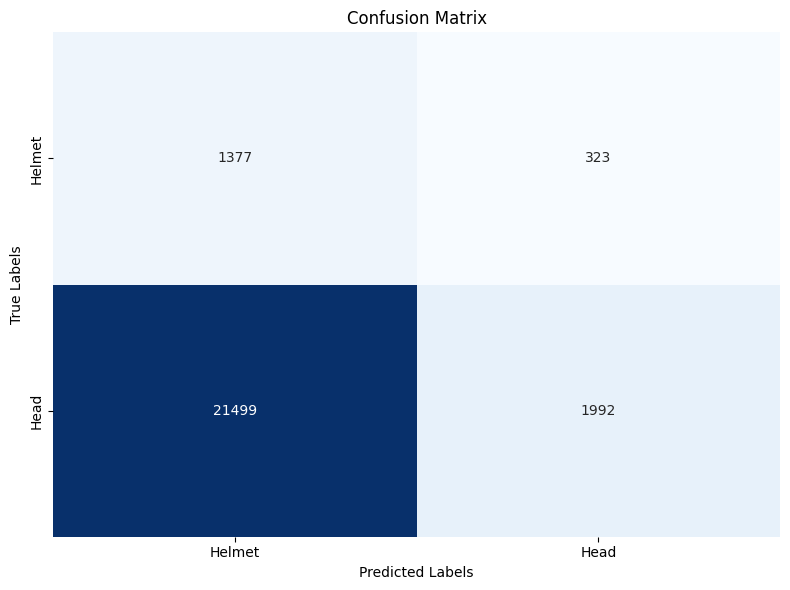

Accuracy: 0.00


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 混同行列の計算と表示
cm = confusion_matrix(labels, predicted_labels_all)
print("Confusion Matrix:")
print(cm)

# ヒートマップとして混同行列を図示
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, 
            xticklabels=['Helmet', 'Head'], yticklabels=['Helmet', 'Head'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# accuracyの計算と表示
accuracy = np.sum(predicted_labels_all == labels) / len(image_paths)
print(f"Accuracy: {accuracy:.2f}")
